In [1]:
# 🔄 Set this to True if you want to load a saved model otherwise False
LOAD_SAVED_MODEL = False

In [2]:
# -----------------------------------------
# 📦 Setup
# -----------------------------------------
!pip install tensorflow --quiet

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)
from sklearn.utils.class_weight import compute_class_weight
import os

print("✅ TensorFlow version:", tf.__version__)

✅ TensorFlow version: 2.18.0


**📁 Part 1 - Data Preprocessing**

In [3]:
# -----------------------------------------
# Part 1 - Simple Data Preprocessing
# -----------------------------------------

# Mount Google Drive (if using Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Not running in Colab - skipping Google Drive mount")

# ✅ Settings
img_size = (224, 224)
batch_size = 32

# ✅ Load Dataset
dataset_path = '/content/drive/MyDrive/dataset_balanced'

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# ✅ Get class names
class_names = train_ds.class_names
print(f"✅ Classes: {class_names}")

# ✅ Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.02),
])

# ✅ Normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# ✅ Performance Boost
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ✅ Compute class weights
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))
print("✅ Class Weights:", class_weights)

# Display label distribution
unique, counts = np.unique(y_train, return_counts=True)
print("✅ Label Distribution:", dict(zip(unique, counts)))


Mounted at /content/drive
Google Drive mounted successfully.
Found 1800 files belonging to 4 classes.
Using 1620 files for training.
Found 1800 files belonging to 4 classes.
Using 180 files for validation.
✅ Classes: ['AH64', 'B1', 'B2', 'E2']
✅ Class Weights: {0: np.float64(0.9975369458128078), 1: np.float64(1.0150375939849625), 2: np.float64(0.995085995085995), 3: np.float64(0.9926470588235294)}
✅ Label Distribution: {np.int32(0): np.int64(406), np.int32(1): np.int64(399), np.int32(2): np.int64(407), np.int32(3): np.int64(408)}


**🧠Part 2 - Building the CNN**

In [4]:
# -----------------------------------------
# Part 2 - Simple & Effective CNN Architecture with Save/Load Feature
# -----------------------------------------

if LOAD_SAVED_MODEL and os.path.exists(model_path):
    # ✅ Load the model from Google Drive
    model = tf.keras.models.load_model(model_path)
    print("✅ Loaded model from Google Drive — training skipped.")
else:
    # ✅ Create a simple but effective CNN
    def create_simple_effective_cnn(num_classes):
        model = models.Sequential([


            # Block 1
            layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_size[0], img_size[1], 3)),
            data_augmentation,
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.1),

            # Block 2
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.1),

            # Block 3
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.1),

            # Block 4
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.1),

            # Dense Layers
            layers.Flatten(),
            layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.2),

            layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.2),

            layers.Dense(num_classes, activation='softmax')
        ])
        return model

    # ✅ Build the model
    model = create_simple_effective_cnn(len(class_names))

    # ✅ Compile the model
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Part 3 - Compiling and Training the CNN**

In [5]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Simple & Effective CNN created successfully")
model.summary()

✅ Simple & Effective CNN created successfully


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,62

 Total params: 26,216,388 (100.01 MB)

 Trainable params: 26,213,892 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [6]:
# -----------------------------------------
# Part 3 - Conservative Training Strategy
# -----------------------------------------

# ✅ Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_simple_cnn.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ✅ Train the model
print("🚀 Training Simple & Effective CNN...")
epochs = 150  # More epochs with early stopping

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ✅ Load best model
model.load_weights('best_simple_cnn.keras')

🚀 Training Simple & Effective CNN...
Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.3943 - loss: 1.6239
Epoch 1: val_accuracy improved from -inf to 0.31111, saving model to best_simple_cnn.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3958 - loss: 1.6214 - val_accuracy: 0.3111 - val_loss: 1.8166 - learning_rate: 0.0010
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5672 - loss: 1.3054
Epoch 2: val_accuracy improved from 0.31111 to 0.42222, saving model to best_simple_cnn.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.5680 - loss: 1.3040 - val_accuracy: 0.4222 - val_loss: 1.8500 - learning_rate: 0.0010
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6701 - loss: 1.0930
Epoch 3: val_accuracy did not improve from 0.42222
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.6702 - loss: 1.0927 - val_accuracy: 0.2500 - val_loss: 1.9919 - learning_rate: 0.0010
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
# ✅ Save full model after training (only needs to be done once)
model.save("/content/drive/MyDrive/fighter_jet_model.keras")
print("✅ Model saved to Google Drive.")


**📈 Part 4 - Evaluate Model**


🔥 Validation Accuracy: 0.8556
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
✅ Precision: 0.8670
✅ Recall: 0.8556
✅ F1-Score: 0.8558

📊 Classification Report:
              precision    recall  f1-score   support

        AH64       0.75      0.98      0.85        44
          B1       0.91      0.78      0.84        51
          B2       0.85      0.81      0.83        43
          E2       0.95      0.86      0.90        42

    accuracy                           0.86       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.86      0.86       180



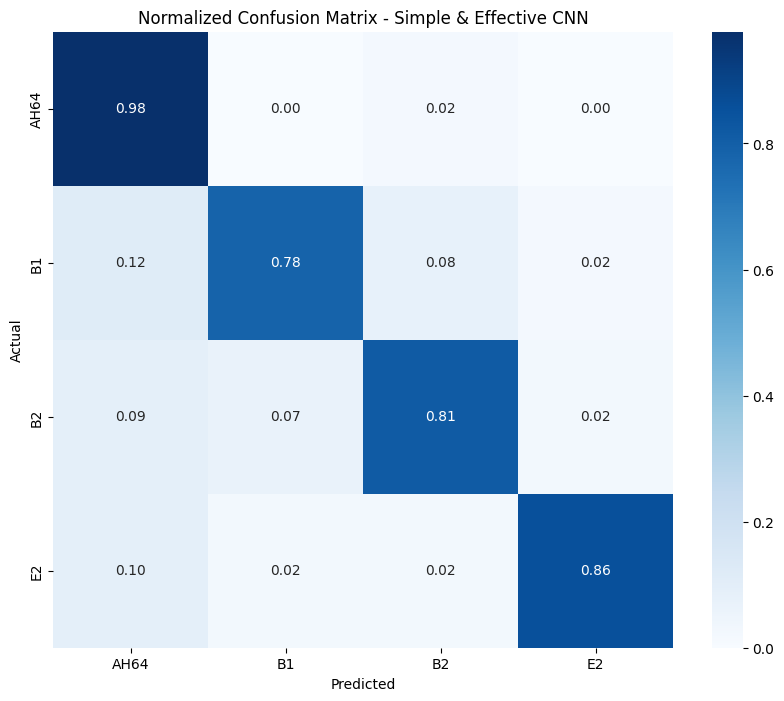

In [7]:
# -----------------------------------------
# Part 4 - Evaluation
# -----------------------------------------

# ✅ Evaluate
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"\n🔥 Validation Accuracy: {val_acc:.4f}")

# ✅ Detailed predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in val_ds], axis=0)

# ✅ Calculate metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1_score:.4f}")

# ✅ Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis],
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix - Simple & Effective CNN")
plt.show()

# ✅ Training History Visualization
# plt.figure(figsize=(10, 5))

# # Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
# plt.title("Accuracy Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# # plt.legend()

# # Loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Val Loss', color='red')
# plt.title("Loss Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# # plt.legend()

# plt.tight_layout()
# plt.show()

**🖼️ Part 5 - Gradio Interface**

In [8]:
# ✅ Install Gradio
!pip install gradio --quiet

import gradio as gr
import tensorflow as tf
import numpy as np

# ✅ Prediction Function
def classify_jet(image):
    image = image.resize(img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    predicted_idx = np.argmax(predictions)
    predicted_label = class_names[predicted_idx]
    confidence = predictions[0][predicted_idx]
    return f"🚀 Predicted: {predicted_label} ({confidence*100:.2f}% confidence)"

# ✅ Launch Gradio Interface
jet_classifier = gr.Interface(
    fn=classify_jet,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Fighter Jet Classifier",
    description="Upload an image of a fighter jet and get the predicted class using CNN"
)

jet_classifier.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://568d0c1ae74c5cd40b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://568d0c1ae74c5cd40b.gradio.live
